implementation of [universal style transfer via feature transforms by Li et al](https://arxiv.org/pdf/1705.08086.pdf)

In [1]:
# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
# make variables display whenever they are on their own line (not just the last line of a cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread
import skimage.transform

from utils import *

C:\Anaconda\envs\style\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Settings

In [6]:
layer = 'conv4'

## Featureize images

In [7]:
compute_features('D:/test2017', out_layer_name='vgg_19/' + layer + '/' + layer + '_1', num_images=5000)
compute_features('D:/val2017', out_layer_name='vgg_19/' + layer + '/' + layer + '_1', num_images=200)

INFO:tensorflow:Restoring parameters from vgg_19.ckpt
INFO:tensorflow:Restoring parameters from vgg_19.ckpt


## Create graph

In [25]:
layer_to_sizes = {
    'conv1': (None, 224, 224, 64),
    'conv2': (None, 112, 112, 128),
    'conv4': (None, 28, 28, 512)
}

tf.reset_default_graph()
sess = tf.Session()
images_ph = tf.placeholder('float', (None, 224, 224, 3), name='images')
features_ph = tf.placeholder('float', layer_to_sizes[layer], name='features')

In [26]:
train_dataset = make_precomputed_dataset('D:/test2017', layer, num_images=5000)
val_dataset = make_precomputed_dataset('D:/val2017', layer, num_images=200)

In [27]:
architecture_4 = [(3, 256), 'upsample', (3, 256), (3, 256), (3, 256), (3, 128), 'upsample', (3, 112), (3, 64), 'upsample', (3, 64), (3, 3)]
architecture_1 = [(3, 3)]
reconstructed_image = make_decoder(features_ph, architecture_4, sess)
loss = create_loss(images_ph, features_ph, reconstructed_image, 'vgg_19/' + layer + '/' + layer + '_1', sess)

INFO:tensorflow:Restoring parameters from vgg_19.ckpt


In [28]:
(train_step, merged) = setup_training(loss, train_dataset, sess, lr=1e-4)

[<tf.Variable 'decoder/conv_layer_0/filters:0' shape=(3, 3, 512, 256) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_0/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_2/filters:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_2/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_3/filters:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_3/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_4/filters:0' shape=(3, 3, 256, 256) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_4/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_5/filters:0' shape=(3, 3, 256, 128) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_5/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_7/filters:0' shape=(3, 3, 128, 112) dtype=float32_ref>, <tf.Variable 'decoder/conv_layer_7/biases:0' shape=(112,) dtype=float32_ref

In [30]:
train(loss, train_step, merged, train_dataset, val_dataset, images_ph, features_ph, sess, num_epochs=5, summary_freq=50)

initial validation loss 385945.61875
training loss 384115.75
training loss 376831.0
validation loss after epoch 0 is 365180.05125
training loss 345704.66
training loss 330576.06
validation loss after epoch 1 is 347943.5525
training loss 331713.7
validation loss after epoch 2 is 337156.03625
training loss 315384.44
training loss 326008.94
validation loss after epoch 3 is 327882.0275
training loss 291584.4
validation loss after epoch 4 is 320167.4675


In [ ]:
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'decoder'))
saver.save(sess, './decoder4/decoder')

## testing

In [ ]:
derp_dataset = make_precomputed_dataset('../val2017', 'conv4', num_images=50)
it = derp_dataset.make_one_shot_iterator()
next_elem = it.get_next()

In [ ]:
img = sess.run(it.get_next())[0]
img = img[np.newaxis,:,:,:]

In [31]:
# img2 = imread('../val2017/000000000139.jpg', pilmode='RGB')
img2 = imread('C:/users/rtimpe/downloads/cat.jpg')
img2 = skimage.transform.resize(img2, (224, 224, 3))
img2 *= 255
# np.square(img - img2).sum()

C:\Anaconda\envs\style\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [ ]:
plt.imshow(np.squeeze(img).astype(np.uint8))
plt.show()
plt.imshow(img2.astype(np.uint8))

In [32]:
encoded_img = encode_image(img2[np.newaxis, :,:,:], 'vgg_19/' + layer + '/' + layer + '_1')
reconstructed = sess.run(reconstructed_image, feed_dict={features_ph: encoded_img})
reconstructed = np.squeeze(reconstructed)

INFO:tensorflow:Restoring parameters from vgg_19.ckpt


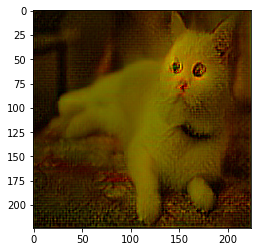

In [33]:
plt.imshow((reconstructed).astype(np.uint8))

In [ ]:
plt.imshow(np.squeeze(img2).astype(np.uint8))


## style transfer stuff

In [46]:
# img = imread('../val2017/000000000139.jpg', pilmode='RGB')
img = imread('C:/users/rtimpe/downloads/cat.jpg')
img = skimage.transform.resize(img, (224, 224, 3))
img = img[np.newaxis, :, :, :]
img = img * 255
encoded_img = encode_image(img, 'vgg_19/' + layer + '/' + layer + '_1')
img.max()


C:\Anaconda\envs\style\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


INFO:tensorflow:Restoring parameters from vgg_19.ckpt


255.0

In [47]:
v = encoded_img.reshape(-1, encoded_img.shape[2]).T
v_centered = v - np.mean(v)
w, _ = whiten(v_centered)
w = np.reshape(w, (1, 28, 28, 512)) + v.mean()

In [48]:
reconstructed = sess.run(reconstructed_image, feed_dict={features_ph: w})
reconstructed = np.squeeze(reconstructed)

In [ ]:
(reconstructed)[reconstructed > 255] = 255

In [42]:
(reconstructed * 2).max()

118.61405

In [41]:
w.max()

438.09738

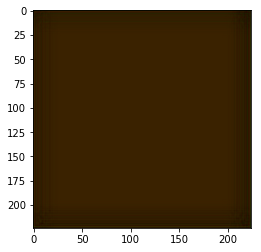

In [49]:
# plt.imshow(((reconstructed[:,:,[2,1,0]])).astype(np.uint8))
# plt.show()
plt.imshow(((reconstructed * 1.0)).astype(np.uint8))

In [ ]:
plt.imshow(np.squeeze(img.astype(np.uint8)))

In [ ]:
def make_test_dataset(data_dir):
    image_filenames = [os.path.join(data_dir, d) for d in os.listdir(data_dir)]
    image_filenames = tf.constant(image_filenames)
    dataset = tf.data.Dataset.from_tensor_slices((image_filenames))
    dataset = dataset.take(2)
    dataset = dataset.batch(38)
    return dataset
test_dataset = make_test_dataset('../val2017')
it = test_dataset.make_one_shot_iterator()
next_elem = it.get_next()
sess.run(next_elem)
# sess.run(next_elem)
# sess.run(next_elem)

In [ ]:
test_dataset.output_shapes

## other crap

In [ ]:
it = dataset.make_one_shot_iterator()

In [ ]:
img,_ = sess.run(it.get_next())
img

In [ ]:
plt.imshow(img)

In [ ]:
decoded_img = sess.run(reconstructed_image, feed_dict={input_ph: img[np.newaxis,:,:,:]})

In [ ]:
decoded_img = np.squeeze(decoded_img)

In [ ]:
decoded_img[decoded_img > 255] = 255

In [ ]:
plt.imshow(decoded_img.astype(np.uint8))

In [ ]:
writer = tf.summary.FileWriter('summaries', sess.graph)

In [ ]:
sess.run(dataset.make_one_shot_iterator().get_next())

In [ ]:
it = dataset.make_one_shot_iterator()
sess.run(it.get_next())[1].shape

In [ ]:
# make_encoder(images_ph, sess)
writer = tf.summary.FileWriter('summaries', sess.graph)